[0.0716681  0.1426418  0.56956962 0.41911956 0.25542842 0.06062813
 0.04101798 0.06062813 0.10492925 0.52198619 0.08092298 0.00175475
 0.00892265 0.00892265 0.04439288 0.41731088 0.25542842 0.14629351
 0.05754653 0.10492925]


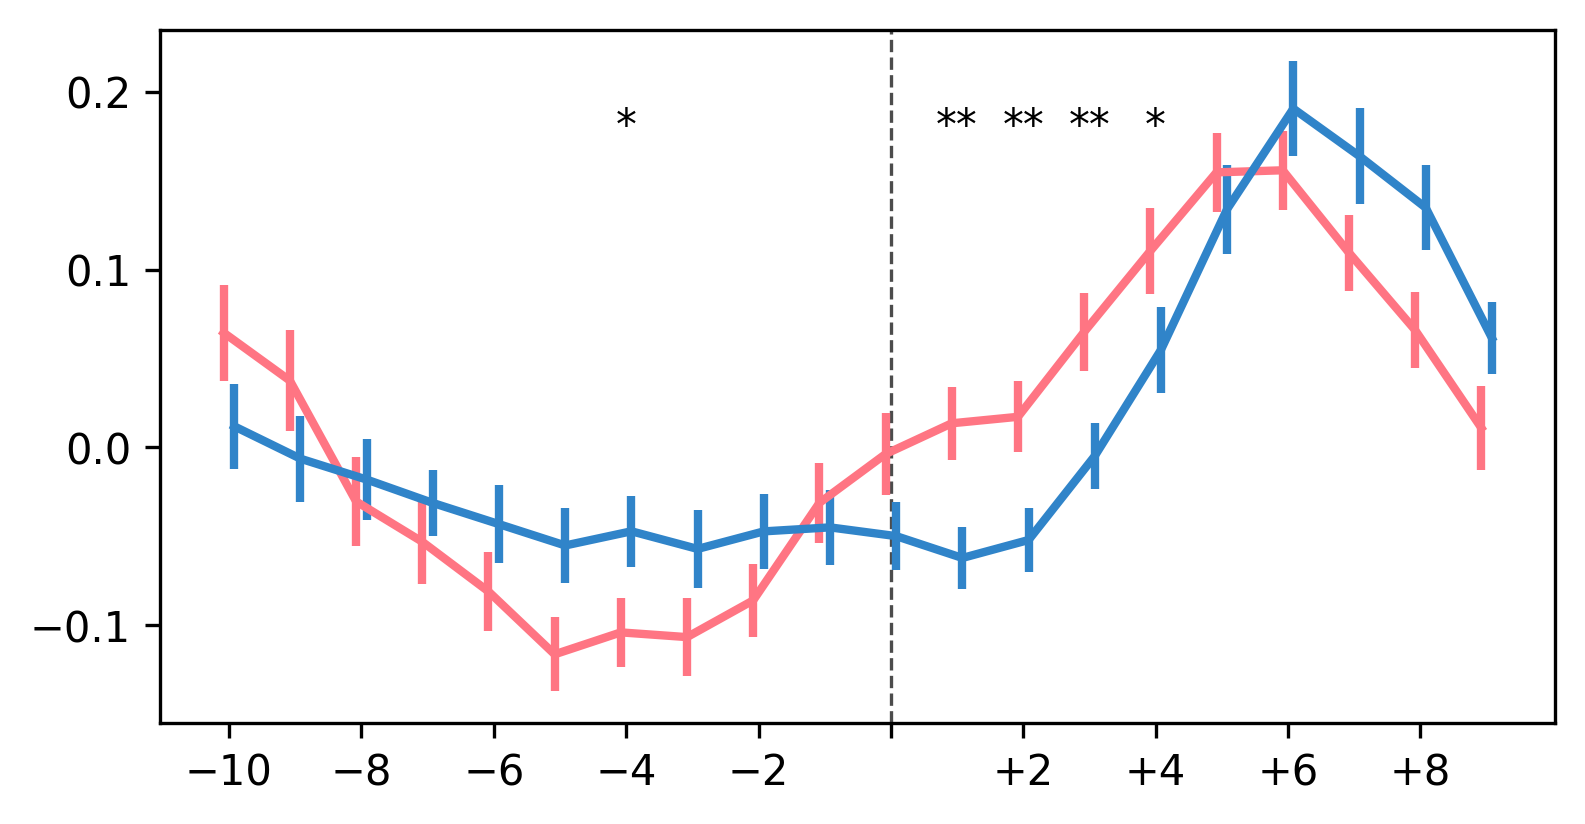

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

hippocampal_patterns = np.load(f'data/replication_hippocampal_pattern.npy', allow_pickle=True)

from scipy.stats import ttest_rel, ttest_ind, sem
plt.style.use('default')

all_event_boundaries = [34,  69,  103, 140, 176, 209, 243, 276, 313, 346, 382, 421, 458, 491, 527, 566, 599]
backward_retrieval_boundaries = [276, 313, 346, 382, 458, 491, 527, 566, 599]
forward_retrieval_boundaries = [103, 209, 276, 346, 421, 527, 566]

time_window = 10
forward_retrieval_activities = []
backward_retrieval_activities = []
for s in range(39):
    hippocampal_timeseries = []
    for r in range(4):
        hippocampal_timeseries.append(hippocampal_patterns[s,r].mean(axis=-1)) # 610, vox
    hippocampal_timeseries = np.mean(hippocampal_timeseries, axis=0)

    tmp_activity = []
    for e, end in enumerate(backward_retrieval_boundaries):
        tmp_activity.append(hippocampal_timeseries[end-time_window:end+time_window])
    backward_retrieval_activities.append(np.mean(tmp_activity, axis=0))

    tmp_activity = []
    for o, onset in enumerate(forward_retrieval_boundaries):
        tmp_activity.append(hippocampal_timeseries[onset-time_window:onset+time_window])
    forward_retrieval_activities.append(np.mean(tmp_activity, axis=0))

backward_retrieval_activities = np.array(backward_retrieval_activities).astype(np.double)
forward_retrieval_activities = np.array(forward_retrieval_activities).astype(np.double)

plt.figure(figsize=(6,3), dpi=300)
plt.axvline(x=time_window, c='k', lw=0.8, alpha=0.7, linestyle='--')

plt.errorbar(np.arange(time_window*2)-0.08,
             np.mean(forward_retrieval_activities, axis=0),
             yerr=sem(forward_retrieval_activities, axis=0),
             c='#ff7583', lw=2)

plt.errorbar(np.arange(time_window*2)+0.08,
             np.mean(backward_retrieval_activities, axis=0),
             yerr=sem(backward_retrieval_activities, axis=0),
             c='#3084c9', lw=2)

from statsmodels.stats.multitest import fdrcorrection
p_list = []
T_list = []
for t in range(time_window*2):
    T, p = ttest_rel(forward_retrieval_activities[:,t], backward_retrieval_activities[:,t])
    p_list.append(p)
    T_list.append(T)

iscorrected, p_corrected = fdrcorrection(p_list)
print(p_corrected)
for t in range(time_window*2):
    if p_corrected[t] < 0.001:
        plt.text(t, 0.18, '***', va='center', ha='center')
    elif p_corrected[t] < 0.01:
        plt.text(t, 0.18, '**', va='center', ha='center')
    elif p_corrected[t] < 0.05:
        plt.text(t, 0.18, '*', va='center', ha='center')
#plt.ylim(-0.07, 0.1)

plt.xticks(np.arange(0, time_window*2, 2),
           ["−10", "−8", "−6", '−4','−2', ' ', '+2', "+4", '+6', "+8"])
plt.yticks([-0.1, 0.00, 0.1, 0.2])
plt.show()

end: paired t-test TtestResult(statistic=2.6866559618384924, pvalue=0.010645657074811765, df=38)
end: t-test (related) TtestResult(statistic=2.7012340168083386, pvalue=0.010263144714064476, df=38)
end: t-test (unrelated) TtestResult(statistic=-0.8786039042537872, pvalue=0.38513804037909305, df=38)
onset: paired t-test TtestResult(statistic=1.0231419047008499, pvalue=0.3127103517165835, df=38)
onset: t-test (related) TtestResult(statistic=1.6124103178895466, pvalue=0.11514829931438046, df=38)
onset: t-test (unrelated) TtestResult(statistic=1.553133814379808, pvalue=0.12868106252719827, df=38)


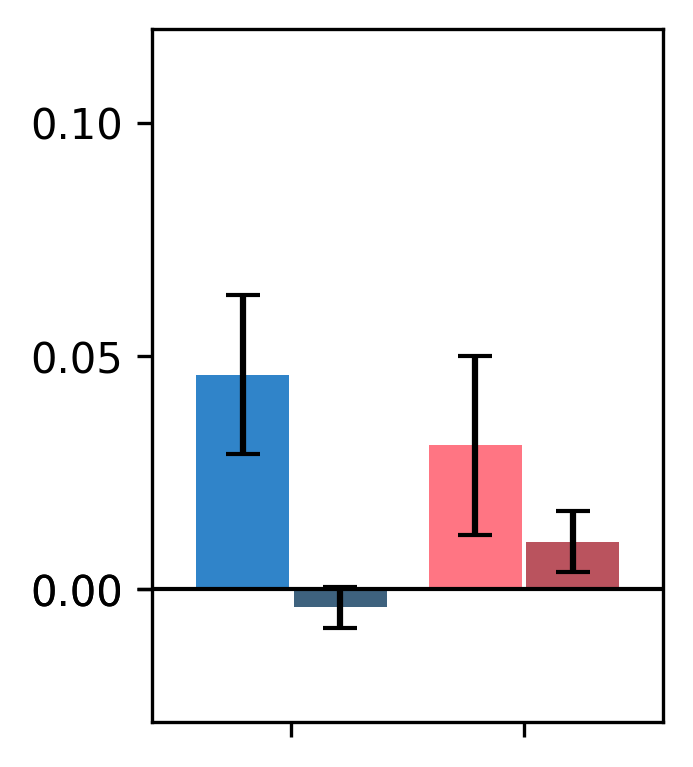

In [13]:
import pickle
from scipy.spatial.distance import cosine
from scipy.stats import ttest_rel, sem, ttest_1samp
plt.style.use('default')

with open('../utils/movie/backward_retrieval_related.pkl', 'rb') as f:
    backward_retrieval_related = pickle.load(f)
with open('../utils/movie/backward_retrieval_unrelated.pkl', 'rb') as f:
    backward_retrieval_unrelated = pickle.load(f)

with open('../utils/movie/forward_retrieval_related.pkl', 'rb') as f:
    forward_retrieval_related = pickle.load(f)
with open('../utils/movie/forward_retrieval_unrelated.pkl', 'rb') as f:
    forward_retrieval_unrelated = pickle.load(f)

ROI_list = ['Hippocampus']
backward_retrieval_offsets = [14]
backward_retrieval_durations = [9]
forward_retrieval_offsets = [1]
forward_retrieval_durations = [3]

r = 0
roi = ROI_list[r]
backward_retrieval_related_result = np.zeros((39, len(backward_retrieval_related)))
backward_retrieval_unrelated_result = np.zeros((39, len(backward_retrieval_unrelated)))
forward_retrieval_related_result = np.zeros((39, len(forward_retrieval_related)))
forward_retrieval_unrelated_result = np.zeros((39, len(forward_retrieval_unrelated)))

for i in range(39):
    if roi == 'Hippocampus':
        roi_patterns = np.hstack([hippocampal_patterns[i,rr] for rr in range(4)])

    backward_offset = backward_retrieval_offsets[r]
    backward_duration = backward_retrieval_durations[r]
    for p, pair in enumerate(backward_retrieval_related):
        prev_patterns = roi_patterns[pair[0]+backward_offset-backward_duration//2:pair[0]+backward_offset-backward_duration//2+backward_duration, :].mean(axis=0)
        next_patterns = roi_patterns[pair[1]-8:pair[1]-2, :].mean(axis=0) # Fixed from activity analysis
        backward_retrieval_related_result[i,p] = 1-cosine(prev_patterns, next_patterns)

    for p, pair in enumerate(backward_retrieval_unrelated):
        prev_patterns = roi_patterns[pair[0]+backward_offset-backward_duration//2:pair[0]+backward_offset-backward_duration//2+backward_duration, :].mean(axis=0)
        next_patterns = roi_patterns[pair[1]-8:pair[1]-2, :].mean(axis=0) # Fixed from activity analysis
        backward_retrieval_unrelated_result[i,p] = 1-cosine(prev_patterns, next_patterns)

    forward_offset = forward_retrieval_offsets[r]
    forward_duration = forward_retrieval_durations[r]
    for p, pair in enumerate(forward_retrieval_related):
        prev_patterns = roi_patterns[pair[0]+forward_offset-forward_duration//2:pair[0]+forward_offset-forward_duration//2+forward_duration, :].mean(axis=0)
        next_patterns = roi_patterns[pair[1]+3:pair[1]+7, :].mean(axis=0) # Fixed from activity analysis
        forward_retrieval_related_result[i,p] = 1-cosine(prev_patterns, next_patterns)

    for p, pair in enumerate(forward_retrieval_unrelated):
        prev_patterns = roi_patterns[pair[0]+forward_offset-forward_duration//2:pair[0]+forward_offset-forward_duration//2+forward_duration, :].mean(axis=0)
        next_patterns = roi_patterns[pair[1]+3:pair[1]+7, :].mean(axis=0) # Fixed from activity analysis
        forward_retrieval_unrelated_result[i,p] = 1-cosine(prev_patterns, next_patterns)

backward_retrieval_related_result = backward_retrieval_related_result.mean(axis=-1)
backward_retrieval_unrelated_result = backward_retrieval_unrelated_result.mean(axis=-1)
forward_retrieval_related_result = forward_retrieval_related_result.mean(axis=-1)
forward_retrieval_unrelated_result = forward_retrieval_unrelated_result.mean(axis=-1)

print("end: paired t-test", ttest_rel(backward_retrieval_related_result, backward_retrieval_unrelated_result))
print("end: t-test (related)", ttest_1samp(backward_retrieval_related_result, popmean=0.0))
print("end: t-test (unrelated)", ttest_1samp(backward_retrieval_unrelated_result, popmean=0.0))

print("onset: paired t-test", ttest_rel(forward_retrieval_related_result, forward_retrieval_unrelated_result))
print("onset: t-test (related)", ttest_1samp(forward_retrieval_related_result, popmean=0.0))
print("onset: t-test (unrelated)", ttest_1samp(forward_retrieval_unrelated_result, popmean=0.0))


backward_related_color = '#3084c9'
backward_unrelated_color = '#3e627e'
forward_related_color = '#ff7583'
forward_unrelated_color = '#ba535e'

plt.figure(figsize=(2.2,3), dpi=300)
plt.bar([0-0.21, 0+0.21],
        [backward_retrieval_related_result.mean(), backward_retrieval_unrelated_result.mean()],
        width=0.4,
        yerr=[sem(backward_retrieval_related_result),
              sem(backward_retrieval_unrelated_result)],
        capsize=4, color=[backward_related_color, backward_unrelated_color])
plt.bar([1-0.21, 1+0.21],
        [forward_retrieval_related_result.mean(), forward_retrieval_unrelated_result.mean()],
        width=0.4,
        yerr=[sem(forward_retrieval_related_result),
              sem(forward_retrieval_unrelated_result)],
        capsize=4, color=[forward_related_color, forward_unrelated_color])

plt.axhline(0, c='k', lw=1)
plt.ylim(-0.12*(0.01/0.042),0.12)
plt.xlim(-0.6, 1.6)
plt.yticks([0,0, 0.05, 0.1])
if r == 0:
    plt.xticks([0,1], ["",""])
else:
    plt.xticks([0,1], ["",""])
    plt.gca().tick_params('x', color='w')
plt.show()